### Linking to the google drive to access any data or files

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the required libraries

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

# Allow duplicate library loading for certain environments (e.g., when using MKL on some platforms)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Initialising all the variables

In [ ]:
# Model names to be used for training or evaluation
model_names = ["densenet121", "resnet34", "mobile_net_v3_large", "efficient_net_b1"]

# Hyperparameters for the training process
num_epochs = 50         # Number of epochs (converted to integer for potential use in calculations)
lr_start = 0.01         # Starting learning rate (converted to float for numerical operations)
lr_end = 0.001          # Ending learning rate (converted to float for numerical operations)
batch_size = 32         # Batch size (converted to integer for operations)

# Initialise a dictionary to store model parameters
model_params = {}

### Loading the validation metrics

In [ ]:
# Load and aggregate training and validation metrics for multiple models
def load_and_aggregate_metrics(model_list, dataset, epochs, batch_size, learning_rate_start, learning_rate_end):

    # Initialize dictionaries to store metrics for each model
    validation_accuracy, validation_loss, validation_targets, validation_predictions = {}, {}, {}, {}
    training_accuracy, training_loss, training_targets, training_predictions = {}, {}, {}, {}

    for model in model_list:
        # Construct file paths for validation and training history files
        validation_file_path = f'/content/drive/MyDrive/models/val_history_{model}_{epochs}.pickle'
        training_file_path = f'/content/drive/MyDrive/models/train_history_{model}_{epochs}.pickle'

        # Load validation history
        with open(validation_file_path, 'rb') as file:
            validation_history = pickle.load(file)

        # Load training history
        with open(training_file_path, 'rb') as file:
            training_history = pickle.load(file)

        # Extract and store metrics for validation
        try:
            validation_accuracy[model] = [value.item() if isinstance(value, np.generic) else value for value in validation_history['acc']]
        except AttributeError:
            validation_accuracy[model] = validation_history['acc']
        validation_loss[model] = validation_history['loss']
        validation_predictions[model] = validation_history['outputs']
        validation_targets[model] = validation_history['targets']

        # Extract and store metrics for training
        training_accuracy[model] = training_history['acc']
        training_loss[model] = training_history['loss']
        training_predictions[model] = training_history['outputs']
        training_targets[model] = training_history['targets']

    # Return aggregated metrics in a dictionary
    return {
        'training_accuracy': training_accuracy,
        'training_loss': training_loss,
        'training_predictions': training_predictions,
        'training_targets': training_targets,
        'validation_accuracy': validation_accuracy,
        'validation_loss': validation_loss,
        'validation_predictions': validation_predictions,
        'validation_targets': validation_targets
    }

### Retreiving the data

In [ ]:
dataset_name = "covid_pneumonia"

# Store the aggregated metrics in the model_params dictionary using the dataset name as the key
model_params[dataset_name] = load_and_aggregate_metrics(model_names, dataset_name, num_epochs, batch_size, lr_start, lr_end)

# Retrieve the keys from the 'training_accuracy' dictionary for the given dataset
model_params[dataset_name]['training_accuracy'].keys()

dict_keys(['densenet121', 'resnet34', 'mobile_net_v3_large', 'efficient_net_b1'])

### Plotting the F1 and Loss plots

In [ ]:
# Define color mappings for accuracy and loss plots
colors_acc = {'covid_pneumonia': 'blue'}
colors_loss = {'covid_pneumonia': 'red'}

# Flags to control which subplot gets specific labels
first_flag = {'densenet121': True, 'resnet34': False, 'efficient_net_b1': False, 'mobile_net_v3_large': False}
second_flag = {'densenet121': False, 'resnet34': True, 'efficient_net_b1': False, 'mobile_net_v3_large': False}
third_flag = {'densenet121': False, 'resnet34': False, 'efficient_net_b1': True, 'mobile_net_v3_large': False}
fourth_flag = {'densenet121': False, 'resnet34': False, 'efficient_net_b1': False, 'mobile_net_v3_large': True}

# Mapping of model short names to full names for plotting
model_names_mapping = {
    'densenet121': "DenseNet 121",
    'resnet34': "ResNet 34",
    'mobile_net_v3_large': "MobileNet V3 Large",
    'efficient_net_b1': "EfficientNet B1"
}

# Mapping of dataset short names to full names for plotting
dataset_names_mapping = {'covid_pneumonia': "COVID + Pneumonia"}

# List of model names to iterate over
model_name_list = ["densenet121", "resnet34", "efficient_net_b1", "mobile_net_v3_large"]

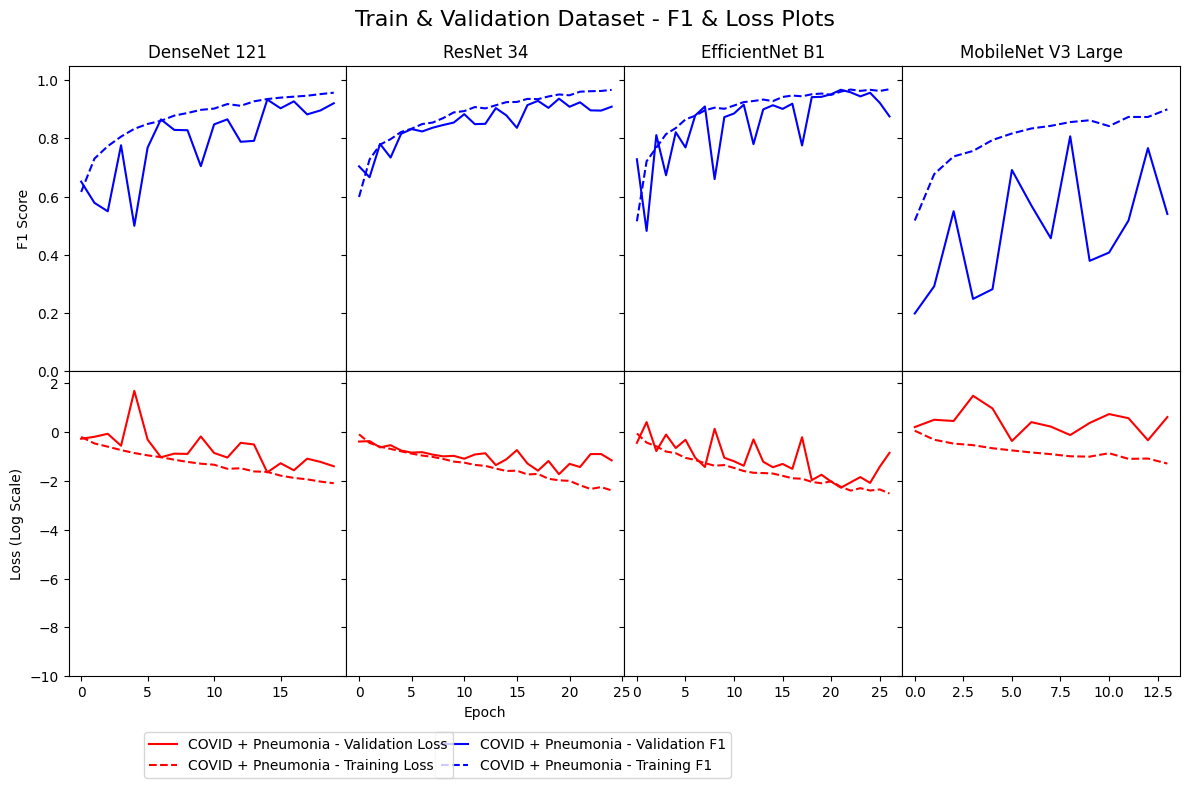

In [ ]:
# Initialize the figure and subplots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 4, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

# Set the title for the entire figure
fig.suptitle('Train & Validation Dataset - F1 & Loss Plots', fontsize=16)

# Loop through the models to plot F1 scores and losses
for i in range(4):  # Adjusted loop to iterate over all four models
    model = model_name_list[i]
    ax1[i].set_title(f'{model_names_mapping[model]}')

    if first_flag[model]:
        ax1[i].set_ylabel('F1 Score')
    if second_flag[model]:
        ax2[i].set_xlabel('Epoch')

    # Determine the number of epochs for this model
    val_epochs = len(model_params['covid_pneumonia']['validation_targets'][model])
    train_epochs = len(model_params['covid_pneumonia']['training_targets'][model])

    # Plot F1 scores for training and validation datasets
    ax1[i].plot(
        range(val_epochs),
        [f1_score(true, pred, average='macro') for true, pred in zip(model_params['covid_pneumonia']['validation_targets'][model], model_params['covid_pneumonia']['validation_predictions'][model])],
        label=f'{dataset_names_mapping["covid_pneumonia"]} - Validation F1',
        color=colors_acc['covid_pneumonia']
    )
    ax1[i].plot(
        range(train_epochs),
        [f1_score(true, pred, average='macro') for true, pred in zip(model_params['covid_pneumonia']['training_targets'][model], model_params['covid_pneumonia']['training_predictions'][model])],
        label=f'{dataset_names_mapping["covid_pneumonia"]} - Training F1',
        color=colors_acc['covid_pneumonia'], linestyle='--'
    )

    ax1[i].tick_params(axis='y', labelcolor='black')
    ax1[i].set_ylim([0, 1.05])

    # Plot loss for training and validation datasets on a logarithmic scale
    if first_flag[model]:
        ax2[i].set_ylabel('Loss (Log Scale)', color='black')

    ax2[i].plot(
        range(val_epochs),
        np.log(model_params['covid_pneumonia']['validation_loss'][model]),
        label=f'{dataset_names_mapping["covid_pneumonia"]} - Validation Loss',
        color=colors_loss['covid_pneumonia']
    )
    ax2[i].plot(
        range(train_epochs),
        np.log(model_params['covid_pneumonia']['training_loss'][model]),
        label=f'{dataset_names_mapping["covid_pneumonia"]} - Training Loss',
        color=colors_loss['covid_pneumonia'], linestyle='--'
    )

    ax2[i].set_ylim([-10, 2.5])
    ax2[i].tick_params(axis='y', labelcolor='black')

    # Add legends if the model is in the second position
    if second_flag[model]:
        ax1[i].legend(bbox_to_anchor=(1., -2.1, 0.41, 0.94))
        ax2[i].legend(bbox_to_anchor=(0., -1.1, 0.41, 0.94))

# Adjust the layout for the entire figure
fig.tight_layout()

### Retriving the validation metrics for the normal and transfer learning variants

In [ ]:
tl_model_params = {}

# Load and aggregate training and validation metrics for a single base model and its transfer learning variant
def get_metrics_tl(model_name, dataset_name, num_epochs, batch_size, lr_start, lr_end):

    # Load metrics from a pickle file
    def load_metrics(file_path):

        with open(file_path, 'rb') as handle:
            return pickle.load(handle)

    # Initialize dictionaries to store metrics for the base model and transfer learning model
    val_acc, val_loss, val_true, val_pred = {}, {}, {}, {}
    train_acc, train_loss, train_true, train_pred = {}, {}, {}, {}

    # File paths for base model
    val_file_base = f'/content/drive/MyDrive/models/val_history_{model_name}_{num_epochs}.pickle'
    train_file_base = f'/content/drive/MyDrive/models/train_history_{model_name}_{num_epochs}.pickle'

    # Load base model metrics
    val_history_base = load_metrics(val_file_base)
    train_history_base = load_metrics(train_file_base)

    # Store base model metrics
    try:
        val_acc[model_name] = [i.item() for i in val_history_base['acc']]
    except:
        val_acc[model_name] = val_history_base['acc']
    val_loss[model_name] = val_history_base['loss']
    val_pred[model_name] = val_history_base['outputs']
    val_true[model_name] = val_history_base['targets']

    train_acc[model_name] = train_history_base['acc']
    train_loss[model_name] = train_history_base['loss']
    train_pred[model_name] = train_history_base['outputs']
    train_true[model_name] = train_history_base['targets']

    # Adjust the model name for transfer learning
    model_name_tl = model_name + "_tl"

    # File paths for transfer learning model
    val_file_tl = f'/content/drive/MyDrive/models/val_history_{model_name_tl}_{num_epochs}.pickle'
    train_file_tl = f'/content/drive/MyDrive/models/train_history_{model_name_tl}_{num_epochs}.pickle'

    # Load transfer learning model metrics
    val_history_tl = load_metrics(val_file_tl)
    train_history_tl = load_metrics(train_file_tl)

    # Store transfer learning model metrics
    try:
        val_acc[model_name_tl] = [i.item() for i in val_history_tl['acc']]
    except:
        val_acc[model_name_tl] = val_history_tl['acc']
    val_loss[model_name_tl] = val_history_tl['loss']
    val_pred[model_name_tl] = val_history_tl['outputs']
    val_true[model_name_tl] = val_history_tl['targets']

    train_acc[model_name_tl] = train_history_tl['acc']
    train_loss[model_name_tl] = train_history_tl['loss']
    train_pred[model_name_tl] = train_history_tl['outputs']
    train_true[model_name_tl] = train_history_tl['targets']

    # Return the aggregated metrics
    return {
        'train_acc': train_acc,
        'train_loss': train_loss,
        'train_pred': train_pred,
        'train_true': train_true,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'val_pred': val_pred,
        'val_true': val_true
    }

### Retreiving the data

In [ ]:
# Retrieve the metrics for "densenet121" and its transfer learning version
tl_model_params[dataset_name] = get_metrics_tl("densenet121", dataset_name, num_epochs, batch_size, lr_start, lr_end)

# Print the keys within 'train_acc' to see the models for which the training accuracy is stored
print(tl_model_params[dataset_name]['train_acc'].keys())

dict_keys(['densenet121', 'densenet121_tl'])


### Plotting the Transfer Learning plots

In [ ]:
# Define color mappings for accuracy and loss plots
colors_acc = {'densenet121': 'orange', 'densenet121_tl': 'dodgerblue'}
colors_loss = {'densenet121': 'orange', 'densenet121_tl': 'dodgerblue'}

# Mapping of model names for plots
model_names = {'densenet121': "W/O Transfer Learning", 'densenet121_tl': "With Transfer Learning"}
dataset_names = {'covid_pneumonia': "COVID + Pneumonia"}

model_name = ["densenet121", "densenet121_tl"]

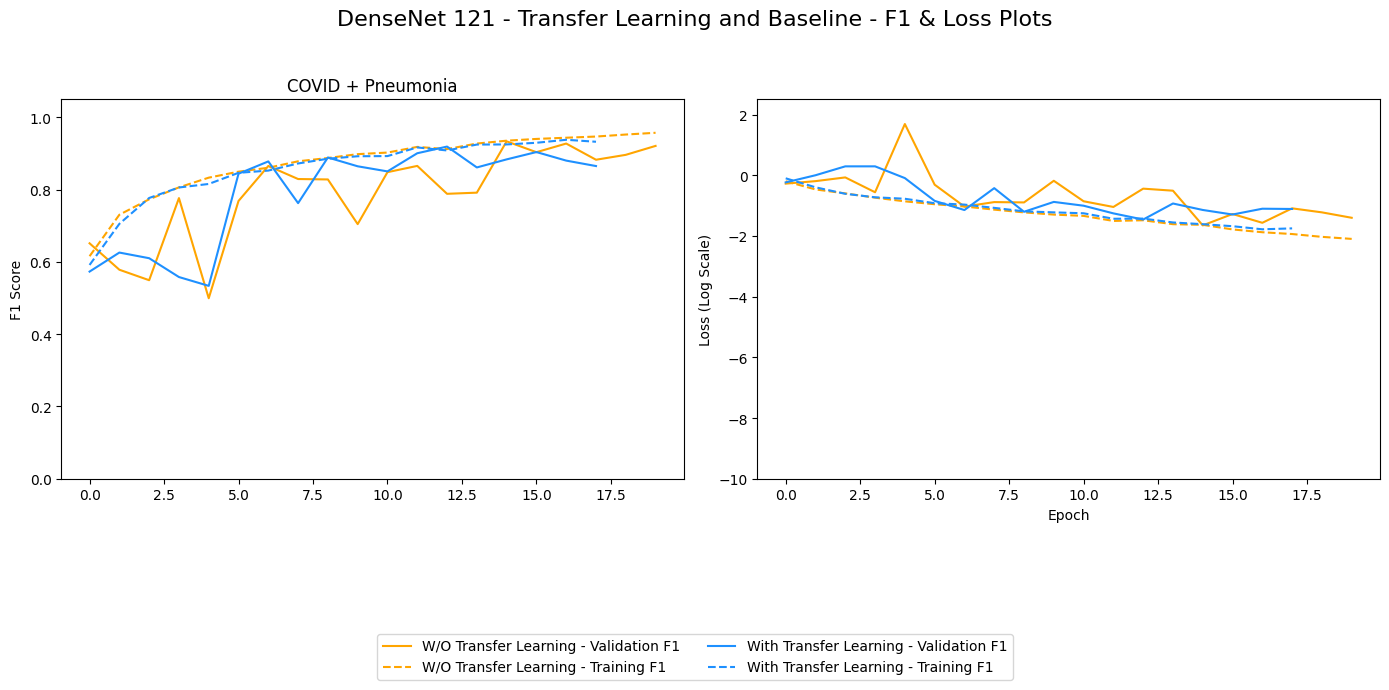

In [ ]:
# Create the figure
fig = plt.figure(figsize=(14, 6))

# Create subplots with some spacing between them
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle(f'DenseNet 121 - Transfer Learning and Baseline - F1 & Loss Plots', fontsize=16)

# Loop through each dataset (in this case, only one)
for curr_dataset, curr_dataset_name in dataset_names.items():
    ax1.set_title(f'{curr_dataset_name}')

    # Plot F1 Scores
    for model in model_name:
        # Ensure we're using the correct number of epochs for each model
        epochs_val = range(len(tl_model_params[curr_dataset]['val_true'][model]))
        epochs_train = range(len(tl_model_params[curr_dataset]['train_true'][model]))

        ax1.plot(
            epochs_val,
            [f1_score(true, pred, average='macro') for true, pred in zip(tl_model_params[curr_dataset]['val_true'][model], tl_model_params[curr_dataset]['val_pred'][model])],
            label=f'{model_names[model]} - Validation F1',
            color=colors_acc[model]
        )
        ax1.plot(
            epochs_train,
            [f1_score(true, pred, average='macro') for true, pred in zip(tl_model_params[curr_dataset]['train_true'][model], tl_model_params[curr_dataset]['train_pred'][model])],
            label=f'{model_names[model]} - Training F1',
            color=colors_acc[model],
            linestyle='--'
        )

    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim([0, 1.05])
    ax1.set_ylabel('F1 Score')

    # Plot Loss
    for model in model_name:
        epochs_val = range(len(tl_model_params[curr_dataset]['val_loss'][model]))
        epochs_train = range(len(tl_model_params[curr_dataset]['train_loss'][model]))

        ax2.plot(
            epochs_val,
            np.log(tl_model_params[curr_dataset]['val_loss'][model]),
            label=f'{model_names[model]} - Validation Loss',
            color=colors_loss[model]
        )
        ax2.plot(
            epochs_train,
            np.log(tl_model_params[curr_dataset]['train_loss'][model]),
            label=f'{model_names[model]} - Training Loss',
            color=colors_loss[model],
            linestyle='--'
        )

    ax2.set_ylim([-10, 2.5])
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel('Loss (Log Scale)')
    ax2.set_xlabel('Epoch')

# Adjust layout to add spacing between plots
plt.subplots_adjust(wspace=0.3)

# Center the legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Tight layout for better spacing
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
